In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import stop_words
from collections import Counter
from tqdm import tqdm
import numpy as np

plt.style.use("ggplot")

In [2]:
import string

# Data understanding

In [3]:
df1 = pd.read_csv("data/result/final/train2.tsv", sep="\t")
df2 = pd.read_csv("data/result/final/test2.tsv", sep="\t")
df3 = pd.read_csv("data/result/final/val2.tsv", sep="\t")

In [4]:
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [5]:
df.head(2)

,json_id,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,...,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,articles
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,negative,not_question,1,3.66,non-curse,disgust,mild gibberish,non-offensive,CENTER,The recent statement from the Annies List poli...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,neutral,question,1,4.26,non-curse,neutral,clean,non-offensive,RIGHT,"The era of coal's dominance is waning, a reali..."


In [6]:
print(df[df["json_id"]=='1626.json']['statement'].values[0])

Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   json_id                   12836 non-null  object 
 1   label                     12836 non-null  object 
 2   statement                 12836 non-null  object 
 3   subject                   12836 non-null  object 
 4   speaker                   12836 non-null  object 
 5   job_title                 9260 non-null   object 
 6   state                     10082 non-null  object 
 7   party_affiliation         12836 non-null  object 
 8   barely_true_counts        12836 non-null  float64
 9   false_counts              12836 non-null  float64
 10  half_true_counts          12836 non-null  float64
 11  mostly_true_counts        12836 non-null  float64
 12  pants_on_fire_counts      12836 non-null  float64
 13  context                   12707 non-null  object 
 14  justif

# Data preparation

In [8]:
df[["statement", "justification"]] = df[["statement", "justification"]].astype(str)

## Add statement and justification length information

In [9]:
df["statement_len"] = df["statement"].apply(len)
df["justification_len"] = df["justification"].apply(len)

## Add word count

In [10]:
df["statement_wc"] = df["statement"].apply(lambda x: len(x.split(" ")))
df["justification_wc"] = df["justification"].apply(lambda x: len(x.split(" ")))
df["articles_wc"] = df["articles"].apply(lambda x: len(str(x).split(" ")))

In [11]:
df[df["articles"].isna()][["label", "statement", "context", "articles"]]

,label,statement,context,articles
2051,barely-true,Says Will Hurd said a border-long U.S.-Mexico ...,a TV ad pointed out to PolitiFact Texas,NaN
4061,barely-true,"In Jeanne Shaheen, New Hampshire has a Senator...",an email,NaN
4922,false,Mitt Romney has 15 homes.,"the video, ""When Mitt Romney Came to Town""",NaN
7300,false,"I balanced the budget for four straight years,...",a Republican presidential debate in Sioux City...,NaN
7500,mostly-true,Says Donald Trump believes that states should ...,a speech at the Democratic National Convention,NaN
8298,pants-fire,Says a man opted out of Obamacare after the ma...,viral posts on the Internet,NaN
9183,half-true,Says weve accomplished balancing two budgets w...,a video,NaN
12728,true,Claims Ohio Gov. John Kasich says climate chan...,a billboard message,NaN


In [12]:
df = df.drop(["json_id"], axis=1)

In [13]:
df.head(2)

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,emotion,gibberish,offensiveness,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,...,disgust,mild gibberish,non-offensive,CENTER,The recent statement from the Annies List poli...,82,248,11,40,205
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,...,neutral,clean,non-offensive,RIGHT,"The era of coal's dominance is waning, a reali...",141,637,24,105,220


## Add two-way label

In [14]:
df["bin_label"] = df["label"].apply(lambda x: "true" if x in ["half-true", "mostly-true", "true"] else "false")

## Label as a score

In [15]:
score = {
    "pants-fire": -3,
    "false": -2,
    "barely-true": -1,
    "half-true": 1,
    "mostly-true": 2,
    "true": 3
}
df["label_score"] = df["label"].apply(lambda x: score[x])

## Add punctuations count per 100 characters

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
df["punctuations"] = df["statement"].apply(lambda s: sum(map(s[:100].count, string.punctuation)))

## How many null values

In [18]:
df.isna().sum()

label                          0
statement                      0
subject                        0
speaker                        0
job_title                   3576
state                       2754
party_affiliation              0
barely_true_counts             0
false_counts                   0
half_true_counts               0
mostly_true_counts             0
pants_on_fire_counts           0
context                      129
justification                  0
sentiment                      0
question                       0
grammar_errors                 0
ratio_of_capital_letters       0
curse                          0
emotion                        0
gibberish                      0
offensiveness                  0
political_bias                 0
articles                       8
statement_len                  0
justification_len              0
statement_wc                   0
justification_wc               0
articles_wc                    0
bin_label                      0
label_scor

## Describe dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   label                     12836 non-null  object 
 1   statement                 12836 non-null  object 
 2   subject                   12836 non-null  object 
 3   speaker                   12836 non-null  object 
 4   job_title                 9260 non-null   object 
 5   state                     10082 non-null  object 
 6   party_affiliation         12836 non-null  object 
 7   barely_true_counts        12836 non-null  float64
 8   false_counts              12836 non-null  float64
 9   half_true_counts          12836 non-null  float64
 10  mostly_true_counts        12836 non-null  float64
 11  pants_on_fire_counts      12836 non-null  float64
 12  context                   12707 non-null  object 
 13  justification             12836 non-null  object 
 14  sentim

In [20]:
df.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,grammar_errors,ratio_of_capital_letters,statement_len,justification_len,statement_wc,justification_wc,articles_wc,label_score,punctuations
count,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000
mean,11.595980,13.369975,17.218838,16.526955,6.246261,0.381505,3.685870,106.286460,426.692350,17.914693,72.078140,211.624961,0.271035,1.937831
std,18.996727,24.150879,35.910604,36.225691,16.162788,0.671460,2.684403,45.013247,309.836223,7.748308,64.631191,14.801490,2.007545,1.535514
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,3.000000,2.000000,1.000000,1.000000,-3.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.890000,73.000000,272.000000,12.000000,46.000000,208.000000,-2.000000,1.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,0.000000,3.170000,99.000000,395.000000,17.000000,67.000000,214.000000,1.000000,2.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000,1.000000,4.760000,133.000000,537.000000,22.000000,90.000000,219.000000,2.000000,3.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000,7.000000,82.140000,395.000000,9394.000000,66.000000,3030.000000,239.000000,3.000000,16.000000


In [21]:
df.describe().to_csv("describtion.csv", float_format="%.3f")

In [22]:
df.duplicated().sum()

0

In [23]:
df.duplicated(subset=["statement"]).sum()

26

In [24]:
df[df.duplicated(subset=["statement"])]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
1014,half-true,On abortion,"abortion,candidates-biography",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,...,RIGHT,The issue of abortion continues to spark heate...,11,394,2,64,219,true,1,0
1826,false,On support for gay marriage.,"civil-rights,families,gays-and-lesbians,marriage",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,...,RIGHT,Public opinion on gay marriage remains a subje...,28,494,5,83,227,false,-2,1
1858,false,"Obama says Iran is a 'tiny' country, 'doesn't ...",foreign-policy,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,...,CENTER,"The President of the United States, Barack Oba...",69,732,12,116,212,false,-2,7
2710,false,On repealing the 17th Amendment,"debates,elections,states",david-dewhurst,Lieutenant governor,Texas,republican,8.0,8.0,10.0,...,RIGHT,"The 17th Amendment, ratified in 1913, dictates...",31,359,5,60,210,false,-2,0
2859,mostly-true,"Four balanced budgets in a row, with no new ta...","job-accomplishments,jobs,state-budget,state-fi...",chris-christie,Governor of New Jersey,New Jersey,republican,10.0,17.0,27.0,...,LEFT,The Garden State is experiencing an economic m...,218,450,38,74,211,true,2,3
3269,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment",tim-pawlenty,NaN,NaN,republican,2.0,3.0,3.0,...,LEFT,"A cap-and-trade system, a cornerstone of envir...",24,290,4,45,197,false,-2,3
4399,false,On the Trans-Pacific Partnership.,trade,pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,...,LEFT,The Trans-Pacific Partnership (TPP) is a monum...,33,315,4,61,219,false,-2,2
4852,half-true,During Sherrod Browns past decade as a D.C. po...,"economy,job-accomplishments,jobs",josh-mandel,Ohio treasurer,Ohio,republican,4.0,5.0,4.0,...,RIGHT,The grim statistics surrounding job losses hav...,203,708,36,117,207,true,1,3
4953,false,On changing the rules for filibusters on presi...,congressional-rules,mitch-mcconnell,Senate minority leader,Kentucky,republican,7.0,6.0,5.0,...,RIGHT,The delicate dance of presidential nominations...,62,856,9,144,213,false,-2,0
6780,half-true,On torture.,"human-rights,terrorism",newt-gingrich,"Co-host on CNN's ""Crossfire""",Georgia,republican,16.0,15.0,20.0,...,RIGHT,"The mere mention of the word ""torture"" evokes ...",11,412,2,64,214,true,1,1


In [25]:
df[df["statement"]=='On abortion']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
709,false,On abortion,"abortion,corrections-and-updates",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,...,RIGHT,"The debate over abortion continues to rage on,...",11,508,2,101,216,false,-2,0
1014,half-true,On abortion,"abortion,candidates-biography",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,...,RIGHT,The issue of abortion continues to spark heate...,11,394,2,64,219,true,1,0


In [26]:
df[df["statement"]=='On torture.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
1071,true,On torture.,military,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,...,RIGHT,The chilling echoes of the Iraq War still reve...,11,513,2,91,216,true,3,1
6780,half-true,On torture.,"human-rights,terrorism",newt-gingrich,"Co-host on CNN's ""Crossfire""",Georgia,republican,16.0,15.0,20.0,...,RIGHT,"The mere mention of the word ""torture"" evokes ...",11,412,2,64,214,true,1,1


In [27]:
df.duplicated(subset=["statement", "label"]).sum()

20

In [28]:
df[df.duplicated(subset=["statement", "label"])]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
1858,false,"Obama says Iran is a 'tiny' country, 'doesn't ...",foreign-policy,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,...,CENTER,"The President of the United States, Barack Oba...",69,732,12,116,212,false,-2,7
2710,false,On repealing the 17th Amendment,"debates,elections,states",david-dewhurst,Lieutenant governor,Texas,republican,8.0,8.0,10.0,...,RIGHT,"The 17th Amendment, ratified in 1913, dictates...",31,359,5,60,210,false,-2,0
3269,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment",tim-pawlenty,NaN,NaN,republican,2.0,3.0,3.0,...,LEFT,"A cap-and-trade system, a cornerstone of envir...",24,290,4,45,197,false,-2,3
4399,false,On the Trans-Pacific Partnership.,trade,pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,...,LEFT,The Trans-Pacific Partnership (TPP) is a monum...,33,315,4,61,219,false,-2,2
4852,half-true,During Sherrod Browns past decade as a D.C. po...,"economy,job-accomplishments,jobs",josh-mandel,Ohio treasurer,Ohio,republican,4.0,5.0,4.0,...,RIGHT,The grim statistics surrounding job losses hav...,203,708,36,117,207,true,1,3
4953,false,On changing the rules for filibusters on presi...,congressional-rules,mitch-mcconnell,Senate minority leader,Kentucky,republican,7.0,6.0,5.0,...,RIGHT,The delicate dance of presidential nominations...,62,856,9,144,213,false,-2,0
6805,false,On support for the Export-Import Bank,trade,glenn-grothman,"State Senator, 20th District",Wisconsin,republican,2.0,4.0,1.0,...,RIGHT,The debate surrounding the Export-Import Bank ...,37,534,6,93,193,false,-2,1
7676,true,Six justices on the U.S. Supreme Court have be...,"congress,legal-issues,supreme-court",gwen-moore,U.S. House member -- 4th District,Wisconsin,democrat,3.0,4.0,4.0,...,RIGHT,The history of the United States Supreme Court...,101,413,16,62,215,true,3,2
8935,true,Says Mitt Romney flip-flopped on abortion.,"abortion,message-machine-2012",jon-huntsman,NaN,Utah,republican,5.0,1.0,5.0,...,CENTER,"In his recent campaign for president, Republic...",42,441,6,74,217,true,3,2
9429,half-true,Twenty million Americans are out of work.,jobs,tom-marino,U.S. representative,Pennsylvania,republican,1.0,1.0,1.0,...,RIGHT,The unemployment rate in the United States rea...,41,628,7,113,211,true,1,1


In [29]:
df[df["statement"]=='On a cap-and-trade plan.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
2885,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,jobs",scott-bruun,State representative,Oregon,republican,2.0,1.0,0.0,...,LEFT,The climate crisis is no longer a distant thre...,24,353,4,54,204,false,-2,3
3269,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment",tim-pawlenty,NaN,NaN,republican,2.0,3.0,3.0,...,LEFT,"A cap-and-trade system, a cornerstone of envir...",24,290,4,45,197,false,-2,3
11454,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,energy,environment",sarah-palin,NaN,Alaska,republican,9.0,19.0,9.0,...,LEFT,The rise of cap-and-trade is being heralded as...,24,470,4,85,215,false,-2,3


In [30]:
df[df["statement"]=='On the Trans-Pacific Partnership.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
2937,false,On the Trans-Pacific Partnership.,trade,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,...,LEFT,"The Trans-Pacific Partnership (TPP), a landmar...",33,1236,4,195,208,false,-2,2
4399,false,On the Trans-Pacific Partnership.,trade,pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,...,LEFT,The Trans-Pacific Partnership (TPP) is a monum...,33,315,4,61,219,false,-2,2


In [31]:
df[df["statement"]=='On high-speed rail.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
3494,false,On high-speed rail.,"corrections-and-updates,stimulus,transportation",mike-haridopolos,Florida Senate President,Florida,republican,0.0,3.0,1.0,...,RIGHT,The world of transportation is undergoing a se...,19,352,3,66,215,false,-2,2
11709,false,On high-speed rail.,"federal-budget,state-budget,transportation",tom-petri,U.S. House member -- 6th District,Wisconsin,republican,0.0,1.0,0.0,...,RIGHT,The world of high-speed rail is poised for rev...,19,282,3,51,194,false,-2,2


### Note

There is no need to remove duplicates because there are no row duplicates and duplicates of statement and label differ in significant way.

# Univariate analysis

In [32]:
df["label"].value_counts()

label
half-true      2638
false          2511
mostly-true    2466
barely-true    2108
true           2063
pants-fire     1050
Name: count, dtype: int64

In [33]:
custom_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]
custom_order2way = ["false", "true"]

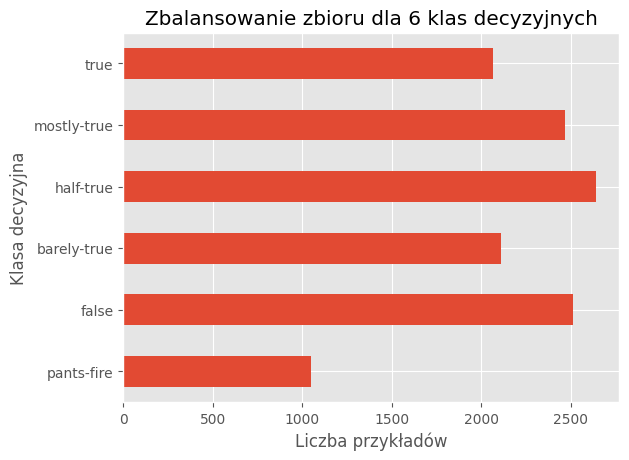

In [34]:
ax = df["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', title="Zbalansowanie zbioru dla 6 klas decyzyjnych")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Klasa decyzyjna")
plt.savefig("imgs/balance_6way.png", bbox_inches='tight')
plt.show()

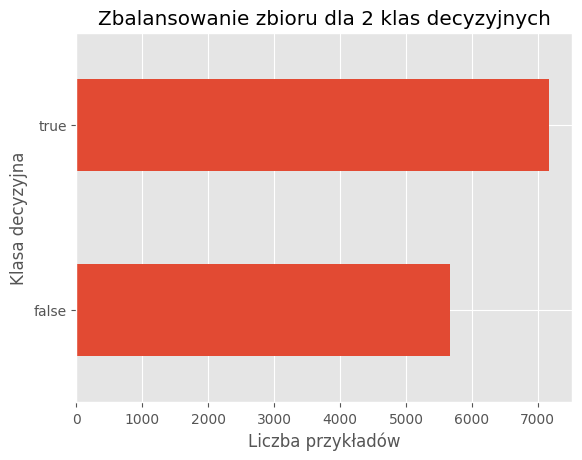

In [35]:
ax = df["bin_label"].value_counts() \
    .reindex(custom_order2way) \
    .plot(kind='barh', title="Zbalansowanie zbioru dla 2 klas decyzyjnych")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Klasa decyzyjna")
plt.savefig("imgs/balance_2way.png", bbox_inches='tight')
plt.show()

## Vocabulary size analysis

In [36]:
nlp = spacy.load("en_core_web_sm")

stop_words = stop_words.STOP_WORDS

example_sentence = nlp("Annie doesn't have a cat")
for w in example_sentence:
    print(w)

Annie
does
n't
have
a
cat


In [37]:
word_counts = Counter()

# Process the column using spaCy's nlp.pipe for efficiency
for doc in nlp.pipe(df['statement'].astype('unicode').values, batch_size=50):
    for token in doc:
        # You can adjust the filters as needed (e.g., filtering stop words)
        if not token.is_punct and not token.is_space:
            word_counts[token.text.lower()] += 1

In [38]:
print('STATEMENT VOCABULARY STATS:\n')
print(f'Vocabulary size: {len(word_counts.items())}')
print(f'Word repeats: {word_counts.total()}')
print(f'Most common words: {word_counts.most_common(20)}')

STATEMENT VOCABULARY STATS:

Vocabulary size: 13969
Word repeats: 235091
Most common words: [('the', 12287), ('in', 6383), ('of', 6032), ('to', 5631), ('a', 4609), ('and', 3589), ('says', 2977), ('for', 2629), ('that', 2448), ('is', 2282), ('on', 1873), ('has', 1639), ('$', 1618), ('have', 1591), ('percent', 1504), ('are', 1413), ('than', 1402), ('we', 1316), ('more', 1196), ('was', 1191)]


In [39]:
word_counts_justification = Counter()

# Process the column using spaCy's nlp.pipe for efficiency
for doc in nlp.pipe(df['justification'].astype('unicode').values, batch_size=50):
    for token in doc:
        # You can adjust the filters as needed (e.g., filtering stop words)
        if not token.is_punct and not token.is_space:
            word_counts_justification[token.text.lower()] += 1

In [40]:
print('JUSTIFICATION VOCABULARY STATS:\n')
print(f'Vocabulary size: {len(word_counts_justification.items())}')
print(f'Word repeats: {word_counts_justification.total()}')
print(f'Most common words: {word_counts_justification.most_common(20)}')

JUSTIFICATION VOCABULARY STATS:

Vocabulary size: 26993
Word repeats: 929228
Most common words: [('the', 55372), ('to', 22423), ('of', 21719), ('that', 19983), ('a', 19182), ('in', 19141), ('and', 16678), ('is', 10763), ('for', 9681), ('but', 7941), ('said', 7931), ('on', 7527), ('it', 7242), ('he', 6382), ('not', 6262), ('was', 6029), ('as', 5472), ('have', 4869), ('we', 4651), ('has', 4638)]


In [41]:
common_word_counts = word_counts + word_counts_justification

# zrobić nową zmienną, usunąć stop_words i wypisać najpopularniejsze słowa bez stop_words

In [42]:
print('COMMON VOCABULARY STATS:\n')
print(f'Vocabulary size: {len(common_word_counts.items())}')
print(f'Word repeats: {common_word_counts.total()}')
print(f'Most common words: {common_word_counts.most_common(20)}')

COMMON VOCABULARY STATS:

Vocabulary size: 28962
Word repeats: 1164319
Most common words: [('the', 67659), ('to', 28054), ('of', 27751), ('in', 25524), ('a', 23791), ('that', 22431), ('and', 20267), ('is', 13045), ('for', 12310), ('on', 9400), ('said', 8395), ('it', 8253), ('but', 8248), ('was', 7220), ('he', 7206), ('not', 7141), ('have', 6460), ('as', 6370), ('has', 6277), ('are', 6029)]


In [43]:
common_words_counts_without_stop_words = Counter()

for k, v in common_word_counts.items():
    if k not in stop_words:
        common_words_counts_without_stop_words[k] = v

In [44]:
print('COMMON VOCABULARY STATS WITHOUT STOPWORDS:\n')
print(f'Vocabulary size: {len(common_words_counts_without_stop_words.items())}')
print(f'Word repeats: {common_words_counts_without_stop_words.total()}')
print(f'Most common words: {common_words_counts_without_stop_words.most_common(10)}')

COMMON VOCABULARY STATS WITHOUT STOPWORDS:

Vocabulary size: 28667
Word repeats: 617537
Most common words: [('said', 8395), ('percent', 4703), ('$', 4537), ('says', 4135), ('state', 3945), ('nt', 3567), ('obama', 3332), ('tax', 3105), ('years', 2697), ('year', 2649)]


## Links analysis

In [45]:
common_word_counts["http"]

0

In [ ]:
common_word_counts["https"]

In [ ]:
common_word_counts["www"]

In [ ]:
df[df["statement"].str.contains("www")]

In [ ]:
df[df["justification"].str.contains("www")]

In [ ]:
[x[x.index("www.")-30:x.index("www.")+50] for x in list(df[df["justification"].str.contains("www")]['justification'])]

In [ ]:
df[df["justification"].str.contains("\.com")]['justification']

In [ ]:
df[df["statement"].str.contains("http")]

In [ ]:
df[df["justification"].str.contains("http")]

## State analysis

In [ ]:
df["state"].value_counts()

In [ ]:
ax = df["state"].value_counts() \
    .head(10) \
    .plot(kind='barh', title="Liczba wypowiedzi w 10 najpopularniejszych stanach")
ax.set_ylabel("Stan")
ax.set_xlabel("Liczba przykładów")

plt.savefig("imgs/state_balance.png", bbox_inches='tight')
plt.show()

In [ ]:
df["speaker"].value_counts().head(10)

In [ ]:
d = {' '.join([x.capitalize() for x in k.split('-')]): v for k, v in df["speaker"].value_counts().head(10).to_dict().items()}
d

In [ ]:
pd.Series(d).to_csv("csv/most_popular_speakers.csv", index_label='speaker', header=['count'])

In [ ]:
ax = df["speaker"].value_counts() \
    .head(10) \
    .plot(kind='barh', title="10 najpopularniejszych mówców")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Kolumna speaker")

plt.savefig("imgs/most_popular_speakers.png", bbox_inches='tight')
plt.show()

In [ ]:
subjects = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    subjects += str(row["subject"]).split(",")

In [ ]:
subjects = pd.DataFrame.from_dict({"subjects": subjects})
subjects["subjects"] = subjects["subjects"].apply(lambda s: s[0] if isinstance(s, tuple) else s)

In [ ]:
subjects.info()

In [ ]:
subjects.describe()

In [ ]:
subjects.value_counts() \
    .head(10)

In [ ]:
ax = subjects["subjects"].value_counts() \
    .head(10) \
    .plot(kind='barh', title="10 najpopularniejszych tematów")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Temat")

plt.savefig("imgs/top_topics.png", bbox_inches='tight')
plt.show()

In [ ]:
print(subjects[:5])

In [ ]:
ax = df["pants_on_fire_counts"].plot(kind="hist", title="Pants-on-fire speaker counts")
ax.set_xlabel("Pants-on-fire counts")

In [ ]:
ax = df["false_counts"].plot(kind="hist", title="False speaker counts")
ax.set_xlabel("False counts")

In [ ]:
ax = df["barely_true_counts"].plot(kind="hist", title="Barely-true speaker counts")
ax.set_xlabel("Barely-true counts")

In [ ]:
ax = df["half_true_counts"].plot(kind="hist", title="Half-true speaker counts")
ax.set_xlabel("Half-true counts")

In [ ]:
ax = df["mostly_true_counts"].plot(kind="hist", title="Mostly-true speaker counts")
ax.set_xlabel("Mostly-true counts")

## Check if there are any non float values in speaker counts

In [ ]:
df[df["pants_on_fire_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

In [ ]:
df[df["false_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

In [ ]:
df[df["barely_true_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

In [ ]:
df[df["mostly_true_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

In [ ]:
df[df["half_true_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

## Check distribution of questions

In [ ]:
df["question"].value_counts()

In [ ]:
ax = df["question"].value_counts() \
    .plot(kind='barh', title="Typy zdań w zbiorze")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Kolumna question")

plt.savefig("imgs/sentences_types.png", bbox_inches='tight')
plt.show()

## Label balance in question vs not_question subsets

### 6-way classification in question subset

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df[df["question"] == 'question']["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', ax=axs[0], title="Zbalansowanie zbioru w podzbiorze question\ndla 6 klas decyzyjnych")
axs[0].set_xlabel("Liczba przykładów")
axs[0].set_ylabel("Klasa decyzyjna")

df["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', ax=axs[1], title="Zbalansowanie zbioru dla 6 klas decyzyjnych")
axs[1].set_xlabel("Liczba przykładów")
axs[1].set_ylabel("Klasa decyzyjna")

plt.tight_layout()
plt.show()

### 6-way classification in not_question subset

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df[df["question"] == 'not_question']["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', ax=axs[0], title="Zbalansowanie zbioru w podzbiorze not_question\ndla 6 klas decyzyjnych")
axs[0].set_xlabel("Liczba przykładów")
axs[0].set_ylabel("Klasa decyzyjna")

df["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', ax=axs[1], title="Zbalansowanie zbioru dla 6 klas decyzyjnych")
axs[1].set_xlabel("Liczba przykładów")
axs[1].set_ylabel("Klasa decyzyjna")

plt.tight_layout()
plt.show()

### Both

In [ ]:
# Oblicz value_counts jako procenty
vc_question = df[df["question"] == 'question']["label"].value_counts(normalize=True).reindex(custom_order, fill_value=0) * 100
vc_all = df["label"].value_counts(normalize=True).reindex(custom_order, fill_value=0) * 100

# Pozycje słupków na osi Y
y = np.arange(len(custom_order))
height = 0.35  # wysokość pojedynczego słupka

# Rysowanie
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs[0].barh(y - height/2, vc_question.values, height=height, label="Podzbiór question")
axs[0].barh(y + height/2, vc_all.values, height=height, label="Cały zbiór")

# Opisy osi
axs[0].set_yticks(y)
axs[0].set_yticklabels(custom_order)
axs[0].set_xlabel("Procent przykładów")
axs[0].set_ylabel("Klasa decyzyjna")
axs[0].set_title("Znormalizowany rozkład klas:\npodzbiór question vs cały zbiór")
axs[0].legend()
axs[0].grid(True, axis='x', linestyle='--', alpha=0.5)

vc_question2 = df[df["question"] == 'not_question']["label"].value_counts(normalize=True).reindex(custom_order, fill_value=0) * 100
vc_all2 = df["label"].value_counts(normalize=True).reindex(custom_order, fill_value=0) * 100

# Pozycje słupków na osi Y
y2 = np.arange(len(custom_order))
height2 = 0.35  # wysokość pojedynczego słupka

axs[1].barh(y2 - height2/2, vc_question2.values, height=height2, label="Podzbiór not_question")
axs[1].barh(y2 + height2/2, vc_all2.values, height=height2, label="Cały zbiór")

# Opisy osi
axs[1].set_yticks(y2)
axs[1].set_yticklabels(custom_order)
axs[1].set_xlabel("Procent przykładów")
axs[1].set_ylabel("Klasa decyzyjna")
axs[1].set_title("Znormalizowany rozkład klas:\npodzbiór not_question vs cały zbiór")
axs[1].legend()
axs[1].grid(True, axis='x', linestyle='--', alpha=0.5)

# Dodanie wartości procentowych na końcu słupków w axs[0]
for i, (v1, v2) in enumerate(zip(vc_question.values, vc_all.values)):
    axs[0].text(v1 / 2, i - height/2, f"{v1:.3f}%", va='center', ha='center', color='white', fontsize=8)
    axs[0].text(v2 / 2, i + height/2, f"{v2:.3f}%", va='center', ha='center', color='white', fontsize=8)

# Dodanie wartości procentowych na końcu słupków w axs[1]
for i, (v1, v2) in enumerate(zip(vc_question2.values, vc_all2.values)):
    axs[1].text(v1 / 2, i - height2/2, f"{v1:.3f}%", va='center', ha='center', color='white', fontsize=8)
    axs[1].text(v2 / 2, i + height2/2, f"{v2:.3f}%", va='center', ha='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig("imgs/questions_balance_per_subsets.png", bbox_inches='tight')
plt.show()

In [ ]:
# Oblicz value_counts jako procenty
vc_question = df[df["question"] == 'question']["bin_label"].value_counts(normalize=True).reindex(custom_order2way, fill_value=0) * 100
vc_all = df["bin_label"].value_counts(normalize=True).reindex(custom_order2way, fill_value=0) * 100

# Pozycje słupków na osi Y
y = np.arange(len(custom_order2way))
height = 0.35  # wysokość pojedynczego słupka

# Rysowanie
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs[0].barh(y - height/2, vc_question.values, height=height, label="Podzbiór question")
axs[0].barh(y + height/2, vc_all.values, height=height, label="Cały zbiór")

# Opisy osi
axs[0].set_yticks(y)
axs[0].set_yticklabels(custom_order2way)
axs[0].set_xlabel("Procent przykładów")
axs[0].set_ylabel("Klasa decyzyjna")
axs[0].set_title("Znormalizowany rozkład klas:\npodzbiór question vs cały zbiór")
axs[0].legend()
axs[0].grid(True, axis='x', linestyle='--', alpha=0.5)

vc_question2 = df[df["question"] == 'not_question']["bin_label"].value_counts(normalize=True).reindex(custom_order2way, fill_value=0) * 100
vc_all2 = df["bin_label"].value_counts(normalize=True).reindex(custom_order2way, fill_value=0) * 100

# Pozycje słupków na osi Y
y2 = np.arange(len(custom_order2way))
height2 = 0.35  # wysokość pojedynczego słupka

axs[1].barh(y2 - height2/2, vc_question2.values, height=height2, label="Podzbiór not_question")
axs[1].barh(y2 + height2/2, vc_all2.values, height=height2, label="Cały zbiór")

# Opisy osi
axs[1].set_yticks(y2)
axs[1].set_yticklabels(custom_order2way)
axs[1].set_xlabel("Procent przykładów")
axs[1].set_ylabel("Klasa decyzyjna")
axs[1].set_title("Znormalizowany rozkład klas:\npodzbiór not_question vs cały zbiór")
axs[1].legend()
axs[1].grid(True, axis='x', linestyle='--', alpha=0.5)

# Dodanie wartości procentowych na końcu słupków w axs[0]
for i, (v1, v2) in enumerate(zip(vc_question.values, vc_all.values)):
    axs[0].text(v1 / 2, i - height/2, f"{v1:.3f}%", va='center', ha='center', color='white', fontsize=12)
    axs[0].text(v2 / 2, i + height/2, f"{v2:.3f}%", va='center', ha='center', color='white', fontsize=12)

# Dodanie wartości procentowych na końcu słupków w axs[1]
for i, (v1, v2) in enumerate(zip(vc_question2.values, vc_all2.values)):
    axs[1].text(v1 / 2, i - height2/2, f"{v1:.3f}%", va='center', ha='center', color='white', fontsize=12)
    axs[1].text(v2 / 2, i + height2/2, f"{v2:.3f}%", va='center', ha='center', color='white', fontsize=12)

plt.tight_layout()
plt.savefig("imgs/questions_balance_per_subsets_2way.png", bbox_inches='tight')
plt.show()

### 2-way classification in question subset

In [ ]:
df[df["question"] == 'question']["bin_label"].value_counts()

In [ ]:
ax = df[df["question"] == 'question']["bin_label"].value_counts() \
    .plot(kind='barh', title="2-way label balance in question subset")

### 2-way classification in not_question subset

In [ ]:
df[df["question"] == 'not_question']["bin_label"].value_counts() \
    .plot(kind='barh', title="2-way label balance in not_question subset")

## Sentiment distribution

In [ ]:
ax = df['sentiment'].value_counts() \
    .plot(kind='barh', title="Rozkład sentymentu w zbiorze")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Kolumna sentiment")

plt.savefig("imgs/sentiment_distibution.png", bbox_inches='tight')
plt.show()

## Check average text length per label class

In [ ]:
df.groupby("label")["statement_len"].mean()

In [ ]:
ax = df.groupby("label")["statement_wc"].mean() \
    .reindex(custom_order) \
    .plot(kind='barh', title="aggregated mean statement word count per label")
ax.set_xlabel("average statement word count")
ax.set_ylabel("label")

In [ ]:
ax = df.groupby("bin_label")["statement_wc"].mean() \
    .plot(kind='barh', title="aggregated mean statement word count per bin_label")
ax.set_xlabel("average statement word count")
ax.set_ylabel("bin_label")

In [ ]:
ax = df.groupby("label")["justification_wc"].mean() \
    .reindex(custom_order) \
    .plot(kind='barh', title="aggregated mean justification word count per label")
ax.set_xlabel("average justification word count")
ax.set_ylabel("label")

In [ ]:
ax = df.groupby("bin_label")["justification_wc"].mean() \
    .plot(kind='barh', title="aggregated mean justification word count per bin_label")
ax.set_xlabel("average justification word count")
ax.set_ylabel("bin_label")

### Verify on small subset

In [ ]:
o = df[df["label"] == "false"].sample(5)[["justification", "justification_wc"]]
o

In [ ]:
o["justification_wc"].mean()

In [ ]:
ax = df.groupby("label")["grammar_errors"].mean() \
    .reindex(custom_order) \
    .plot(kind='barh', title="aggregated mean grammar errors per 6-way label")
ax.set_ylabel("6-way label")
ax.set_xlabel("average grammar errors")

In [ ]:
ax = df.groupby("bin_label")["grammar_errors"].mean() \
    .reindex(["false", "true"]) \
    .plot(kind='barh',
          title="aggregated mean grammar errors per 2-way label")
ax.set_ylabel("2-way label")
ax.set_xlabel("average grammar errors")

## State vs political affiliation counts

In [ ]:
n = 10

# Count total messages per state and get the top n
state_counts_total = df["state"].value_counts().nlargest(n)
top_states = state_counts_total.index  # Get state names

# Filter dataset to only include top n states
filtered_df = df[df["state"].isin(top_states)]

# Count occurrences per state and party
state_counts = filtered_df.groupby(["state", "party_affiliation"]).size().reset_index(name="count")

# Enforce state order based on total count
state_counts["state"] = pd.Categorical(state_counts["state"], categories=top_states, ordered=True)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=state_counts, x="state", y="count", hue="party_affiliation", palette="tab10", order=top_states)

# Formatting
plt.xlabel("Stan")
plt.ylabel("Liczba przykładów")
plt.title(f"Liczba wypowiedzi na stan na przynależność partyjną ({n} najpopularniejszych stanów)")
plt.legend(title="Przynależność partyjna", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("imgs/statements_vs_state_vs_party_affiliation.png", bbox_inches='tight')
plt.show()

## Party affiliation counts

In [ ]:
df['party_affiliation'].value_counts()

In [ ]:
ax = df['party_affiliation'].value_counts() \
    .head(10) \
    .plot(kind='barh', title="Przynależność partyjna w zbiorze (10 najpopularniejszych)")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Kolumna party_affiliation")

plt.savefig("imgs/party_affiliation.png", bbox_inches='tight')
plt.show()
# zastanowić się czy nie dać skali logarytmicznej

# Feature Relationships

In [ ]:
# Compute frequency of each grammar_errors value
df["error_count"] = df.groupby(["label", "grammar_errors"])["grammar_errors"].transform("count")

# Create scatter plot with hue as frequency count
ax = sns.scatterplot(
    x=pd.Categorical(df["label"], categories=custom_order, ordered=True),
    y="grammar_errors",
    hue="error_count",  # Hue based on frequency
    size="error_count",  # Optional: Make points bigger for frequent values
    palette="viridis",  # Change color map to highlight differences
    data=df
)

ax.set_title("Label Score vs Grammar Errors (Hue = Frequency)")
ax.legend(title="Count of Occurrences")

df.drop("error_count", axis=1, inplace=True)

In [ ]:
df[df['grammar_errors']==7]

In [ ]:
df.groupby(['label', 'grammar_errors'])["grammar_errors"].count()

#### Ciąg dalszy...

In [ ]:
grouped = df.groupby("label", observed=True)["grammar_errors"]
means = grouped.mean().reindex(custom_order)
stds = grouped.std().reindex(custom_order)  # Standard deviation (for error bars)
medians = grouped.median().reindex(custom_order)

labels = means.index
y = np.arange(len(labels))
x = means.values
xerr = stds.values

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs[0].errorbar(x, y, xerr=[xerr, xerr], fmt='s', capsize=4, color='coral', label='średnia ± std')

# Dodaj mediany
axs[0].scatter(medians.values, y, color='blue', label='mediana', zorder=3)

axs[0].set_yticks(y, labels)
axs[0].set_yticklabels(labels)
axs[0].set_xlabel("Średnia liczba błędów gramatycznych")
axs[0].set_ylabel("Klasa decyzyjna")
axs[0].set_title("Błędy gramatyczne na klasę decyzyjną\n(6 klas, średnia ± odchylenie standardowe, mediana)")
axs[0].legend()
axs[0].grid(True, axis='x', linestyle='--', alpha=0.5)

df["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', ax=axs[1], title="Zbalansowanie zbioru dla 6 klas decyzyjnych")
axs[1].set_xlabel("Liczba przykładów")
axs[1].set_ylabel("Klasa decyzyjna")

plt.tight_layout()

plt.savefig("imgs/grammar_errors_vs_label_6way.png", bbox_inches='tight')
plt.show()


In [ ]:
grouped = df.groupby("bin_label", observed=True)["grammar_errors"]
means = grouped.mean()
stds = grouped.std()  # Standard deviation (for error bars)
medians = grouped.median()

labels = means.index
y = np.arange(len(labels))
x = means.values
xerr = stds.values

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs[0].errorbar(x, y, xerr=[xerr, xerr], fmt='s', capsize=4, color='coral', label='średnia ± std')

# Dodaj mediany
axs[0].scatter(medians.values, y, color='blue', label='mediana', zorder=3)

axs[0].set_yticks(y, labels)
axs[0].set_yticklabels(labels)
axs[0].set_xlabel("Średnia liczba błędów gramatycznych")
axs[0].set_ylabel("Klasa decyzyjna")
axs[0].set_title("Błędy gramatyczne na klasę decyzyjną\n(2 klasy, średnia ± odchylenie standardowe, mediana)")
axs[0].legend()
axs[0].grid(True, axis='x', linestyle='--', alpha=0.5)

df["bin_label"].value_counts() \
    .reindex(custom_order2way) \
    .plot(kind='barh', ax=axs[1], title="Zbalansowanie zbioru dla 2 klas decyzyjnych")
axs[1].set_xlabel("Liczba przykładów")
axs[1].set_ylabel("Klasa decyzyjna")

plt.tight_layout()
plt.savefig("imgs/grammar_errors_vs_label_2way.png", bbox_inches='tight')
plt.show()


In [ ]:
ax = sns.scatterplot(x='statement_len',
                y='grammar_errors',
                hue='label_score',
                data=df)
ax.set_title("statement length vs grammar errors vs label score")

In [ ]:
df.plot(kind='scatter',
        x='label',
        y='barely_true_counts',
        title='label score vs barely true counts')
# tego typu wykresów nie wrzucać do pracy inżynierskiej

In [ ]:
ax = sns.scatterplot(x='grammar_errors',
                     y='punctuations',
                     hue='label_score',
                     data=df)
ax.set_title("grammar errors vs punctuations vs label score")

In [ ]:
ax = df.groupby("label", observed=True)["punctuations"] \
    .mean() \
    .reindex(custom_order) \
    .plot(kind="barh")

ax.set_xlabel("Mean punctuations")
ax.set_title("Mean punctuations per label")

In [ ]:
sns.pairplot(df,
             vars=[
                 'barely_true_counts',
                 'false_counts',
                 'half_true_counts',
                 'mostly_true_counts',
                 'pants_on_fire_counts'
             ],
             hue='label')
plt.show()

In [ ]:
sns.pairplot(df,
             vars=[
                 'statement_wc',
                 'punctuations',
                 'grammar_errors'
             ],
             hue='label')
plt.show()

In [ ]:
df.groupby(["label", "sentiment"]).size()

In [ ]:
df.groupby(["label", "sentiment"]).size().unstack()

In [ ]:
ax = sns.countplot(data=df, x="label", hue="sentiment", order=custom_order)
ax.set_title("Zestawienie kolumn label vs sentiment (6 klas decyzyjnych)")
ax.set_ylabel("Liczba przykładów")
ax.set_xlabel("Kolumna label")

plt.savefig("imgs/label_vs_sentiment_6way.png")
plt.show()

In [ ]:
ax = sns.countplot(data=df, x="bin_label", hue="sentiment")
ax.set_title("Zestawienie kolumn bin_label vs sentiment (2 klasy decyzyjne)")
ax.set_ylabel("Liczba przykładów")
ax.set_xlabel("Kolumna bin_label")

plt.savefig("imgs/label_vs_sentiment_2way.png")
plt.show()

In [ ]:
df_numeric = df.select_dtypes(include='number')
correlation_matrix = df_numeric.corr()
correlation_matrix

In [ ]:
# Wybieramy tylko kolumny liczbowe (podstawowo wybiera też tekstowe i próbuje przekonwertować)
df_numeric = df.select_dtypes(include='number')
corr_matrix = df_numeric.corr()

# Ustal próg korelacji
threshold = 0.2

# Przechodzimy przez górny trójkąt macierzy korelacji, pomijając przekątną
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr.append((col1, col2, corr_value))

# Wyświetlenie wyników
for col1, col2, value in high_corr:
    print(f"{col1} vs {col2}: korelacja = {value:.3f}")